# Reproducing results from the ammonia dynamic catalysis paper

Now mainly based on the (probably incomplete and outdated) [code found on GitHub](https://github.com/VlachosGroup/NH3-Dynamic-MKM/tree/main).

Observations about the code:

- reaction rate equations are build and then used in the ODEs
- rate constants of forward steps are calculated with the Arrhenius equations and of reverse steps using the equilibrium constant
- all 19 reactions below are considered, forward and reverse + other 3 for diffusion

22 Reactions:
    
Terrace:\
    0. N2   +  \*(T) <--> N2(T) \
    1. N2(T)  +  \*(T) <--> 2N(T) \
    2. H2   + 2(T) <--> 2H(T)\
    3. NH3(T) +  \*(T) <--> NH2(T) + H(T) (note that this is the reverse of ammonia formation)\
    4. NH2(T) +  \*(T) <--> NH(T)  + H(T)\
    5. NH(T)  +  \*(T) <--> N(T)   + H(T)\
    6. NH3  +  \*(T) <--> NH3(T)
    
    
Steps:\
    7. N2 + \*(S) <--> N2(S1)\
    8. N2(S) + \*(S) <--> 2N(S) (considered as non-happening)\
    9. H2 + 2(S) <--> 2H(S)\
    10. NH3(S) + \*(S) <--> NH2(S) + H(S)\
    11. NH2(S) + \*(S) <--> NH(S) + H(S)\
    12. NH(S) + \*(S) <--> N(S) + H(S)\
    13. NH3  +  \*(S) <--> NH3(S)
    
Diffusion:\
    14. N(T) + \*(S) <--> N(S) + \*(T)\
    15. H(T) + \*(S) <--> H(S) + \*(T) (considered as non-happening)\
    16. NH3(T) + \*(S) <--> NH3(S) + \*(T)\
    17. NH2(T) + \*(S) <--> NH2(S) + \*(T)\
    18. NH(T) + \*(S) <--> NH(S) + \*(T)\
    19. N2(S) + \*(T) <--> N(S) + N(T) (considered as non-happening)\
    20. N2(S) + \*(S3) <--> N(S) + N(S3)\
    21. N(T) + \*(S3) <--> N(S3) + \*(T)

kf are rate constant for the forward reactions depicted above
kb are rate constants for the backward reactions depicted above


16 Species:
    
Terrace:\
    0. N2(T)\
    1. N(T)\
    2. H(T)\
    3. NH3(T)\
    4. NH2(T)\
    5. NH(T)

Gas phase:\
    6. N2\
    7. H2\
    8. NH3
    
Steps:\
    9. N2(S)\
    10. N(S)\
    11. H(S)\
    12. NH3(S)\
    13. NH2(S)\
    14. NH(S)\
    15. N(S3)
    
The listed numbers are the indexes for the ODEs for each species

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import root 
import math
from scipy import signal
from scipy.special import erf
import pandas as pd
from IPython.display import Image, display
from munch import Munch
import numpy as np
from scipy.optimize import root
from tqdm import tqdm

In [2]:
SDTOT = 2.6188e-9                # Total catalyst site density (moles/cm2)
RATIO_S = 0.02                   # Fraction of Step sites
SDEN_T = (1 - RATIO_S) * SDTOT   # Catalyst terrace site density
SDEN_S = RATIO_S * SDTOT         # Catalyst step site density

abyv = 1200                      # Catalyst loading (cm2 catalyst/cm3 reac volume)

# Molecular mass values (g/mol)
MW_H = 1.00797
MW_N = 14.0067
MW_H2 = 2*MW_H             
MW_N2 = 2*MW_N             
MW_NH3 = MW_N + 3*MW_H

MWON = 0

T_orig = 593.15                                     
T_gas = 593.15

# Mole fraction feeding
X_H2  = 3                     
X_N2  = 1                   
X_NH3 = 0       

# Normalized mole fractions
Y_H2  = X_H2 /(X_H2+X_N2+X_NH3)
Y_N2  = X_N2 /(X_H2+X_N2+X_NH3)
Y_NH3 = X_NH3/(X_H2+X_N2+X_NH3)  

# Inlet pressure
P = 50 #(atm)
T = 593.15 #(K)

T_c = 500 # K

V = 1.0                       # Reactor volume (cm3)
# %Q_in = 1.0*T_orig/298.15/P;    % 0 = Batch Reactor,  Any other value = CSTR [cm3/s]
Q_in = 1                 # 0 = Batch Reactor,  Any other value = CSTR [cm3/s]
Q_out = 1

R_e = 1.987e-3                 # Gas constant, (kcal/mol K)
R_k = 8.31451e7                # Gas constant, (g cm2/mol K s)
R = 82.057                     # Gas constant, (cm3 atm/K mol)
c_tot = P/(R*T);               # Total starting moles in reactor [mol/cm3]

# Initial concentration values (mol/cm3)
c_H2 = Y_H2*c_tot
c_N2 = Y_N2*c_tot
c_NH3 = Y_NH3*c_tot

freq_osci  = 1000
period = 1 / freq_osci

beta = np.array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
Stick = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
Isobaric = 0

# Other pre exponential values are filled after calculations
A = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1.56E19, 1.56E19, 1.56E19, 1.56E19, 1.56E19, 0, 0, 1.56E19])

A = A.reshape(16,1)

In [3]:
SDEN_T, SDEN_S,  c_H2, c_N2, c_NH3

(2.566424e-09, 5.2376e-11, 0.0007704617767076011, 0.000256820592235867, 0.0)

## Reactor and catalyst parameters

In [4]:
Stoic = np.loadtxt('Stoic.csv', delimiter=',')

# Stoic

In [5]:
matrix = np.zeros((22, 18))

matrix[0, 6] = -1
matrix[2, 7] = -1
matrix[7, 6] = -1
matrix[6, 8] = -1
matrix[9, 7] = -1
matrix[13, 8] = -1

Stoic_gas = matrix

In [6]:
# Linear Scaling Relationships for enthalpy with strain changes
# Page 13 of paper SI

StrainCoef = [-0.04, 0.0, 0.04]

Strain_H = np.loadtxt('Strains_H.csv', delimiter=',')

strain_H_sets = Strain_H / R_e

Strain_Coef_H = np.zeros((13, 2))

# Fit a line for each data set and fill in the Strain_Coef_H matrix
for i, data_set in enumerate(strain_H_sets):
    SCH = np.polyfit(StrainCoef, data_set, 1)
    Strain_Coef_H[i, :] = SCH

# Strain_Coef_H

In [7]:
# Linear Scaling Relationships for entropy with strain changes
# Page 14 of paper SI

Strain_S = np.loadtxt('Strains_S.csv', delimiter=',')

strain_S_sets = Strain_S / R_e / 1000

Strain_Coef_S = np.zeros((13, 3))

# fit a parabola for each data set and fill in the strain_coef_H matrix
for i, data_set in enumerate(strain_S_sets):
    SCS = np.polyfit(StrainCoef, data_set, 2)
    Strain_Coef_S[i, :] = SCS

# Strain_Coef_S

In [8]:
# Linear Scaling Relationships for pre-exponential factors with strain changes
# Page 15 of paper SI


A_Strain_N2_T = np.array([9.05e17, 4.32e17, 5.94e17])* (1 - 0.17) / (1 - RATIO_S)
A_Strain_NH3_T =  np.array([1.32e18, 1.08e18, 1.26e18])* (1 - 0.17) / (1 - RATIO_S)
A_Strain_NH2_T =  np.array([7.68e18, 5.25e18, 4.74e18])* (1 - 0.17) / (1 - RATIO_S)
A_Strain_NH_T =  np.array([3.58e19, 1.53e19, 1.17e19])* (1 - 0.17) / (1 - RATIO_S)
A_Strain_N2_S =  np.array([2.40e19, 2.59e19, 2.65e19])* 0.17 / RATIO_S
A_Strain_NH3_S =  np.array([1.17e18, 7.46e18, 3.21e18])* 0.17 / RATIO_S
A_Strain_NH2_S =  np.array([4.49e19, 5.30e19, 5.43e19])* 0.17 / RATIO_S
A_Strain_NH_S =  np.array([4.70e19, 4.28e19, 4.18e19])* 0.17 / RATIO_S
A_Strain_N2_ST =  np.array([8.18e18, 8.81e18, 9.02e18])* ((1 - 0.17) + 0.17) / ((1 - RATIO_S) + RATIO_S)
A_Strain_N2_S3 =  np.array([8.18e18, 8.81e18, 9.02e18])* ((1 - 0.17) + 0.17) / ((1 - RATIO_S) + RATIO_S)

A_LSR = np.zeros((10, 3))

A_LSR[0, :] = np.polyfit(StrainCoef, A_Strain_N2_T, 2)  # N2(T) + RU(T) = TS4_N2(T) = 2N(T) + RU(B)
A_LSR[1, :] = np.polyfit(StrainCoef, A_Strain_NH3_T, 2)  # NH3(T) + RU(T) = TS1_NH3(T) = H(T) + NH2(T) + RU(B)
A_LSR[2, :] = np.polyfit(StrainCoef, A_Strain_NH2_T, 2)  # NH2(T) + RU(T) = TS2_NH2(T) = H(T) + NH(T) + RU(B)
A_LSR[3, :] = np.polyfit(StrainCoef, A_Strain_NH_T, 2)  # NH(T) + RU(T) = TS3_NH(T) = N(T) + H(T) + RU(B)
A_LSR[4, :] = np.polyfit(StrainCoef, A_Strain_N2_S, 2)  # N2(S) + RU(S) = TS4_N2(S) = 2N(S) + RU(B)
A_LSR[5, :] = np.polyfit(StrainCoef, A_Strain_NH3_S, 2)  # NH3(S) + RU(S) = TS1_NH3(S) = H(S) + NH2(S) + RU(B)
A_LSR[6, :] = np.polyfit(StrainCoef, A_Strain_NH2_S, 2)  # NH2(S) + RU(S) = TS2_NH2(S) = H(S) + NH(S) + RU(B)
A_LSR[7, :] = np.polyfit(StrainCoef, A_Strain_NH_S, 2)  # NH(S) + RU(S) = TS3_NH(S) = N(S) + H(S) + RU(B)
A_LSR[8, :] = np.polyfit(StrainCoef, A_Strain_N2_ST, 2)  # N2(S) + RU(T) = TS4_N2(S) = N(S) + N(T) + RU(B)
A_LSR[9, :] = np.polyfit(StrainCoef, A_Strain_N2_S3, 2)  # N2(S) + RU(T) = TS4_N2(S) = N(S) + N(S3) + RU(B)

## Rate constants as directly given by MATLAB

Taken from a list after the run ends. Shortcut from calculating the rate constants from strain, which is plugged in linear scaling relationships, from which A and Ea are calculated. 

The k's are not influenced by changes in pressure, concentration and other reactor parameters excluding temperature.

## Implementing all steps to get to the rate constants

### Fixed data - NASA polynomials coefficients

In [9]:
A_h = np.loadtxt('A_h.csv', delimiter=',')

A_l = np.loadtxt('A_l.csv', delimiter=',')

### Function to determine which sets of 'A' will be used, depending on temperature

I fixed the temperature in 593 K since it is the temperature that shows the most in the paper. 

In [10]:
def amm_thermo4(T,A6_LSR,A6_Strain,A7_Strain):
    """
    This function uses thermodynamic parameters depending on the temperature and calculates 
    and returns Cp/R, H/RT and G/RT
    """
    
    if T > T_c:
        A_thermo = A_h
    else:
        A_thermo = A_l

        
    # Necessary to vectorize A, which is given as an "array of arrays" in python
    A_thermo = np.array(A_thermo)
    
    A6_LSR = A6_LSR.reshape(13,1)
    
    A6_Strain = A6_Strain.reshape(13,1)
    
    A7_Strain = A7_Strain.reshape(13,1)
    
    
    # A6_Cov depends on the maximum concentration of step and terrace adsorbates
    # so it changes at each time step
    A6_Correction = A6_LSR + A6_Strain
#     A6_Correction = A6_LSR + A6_Cov - A6_Strain

#     print(A_thermo[:, 5])
#     print('-------------')

    # Subtract A6_Correction from specific rows of column 6 in A
    A_thermo[0:6, 5] += A6_Correction[0:6, 0]
    A_thermo[10:16, 5] += A6_Correction[6:12, 0]
    A_thermo[17, 5] += A6_Correction[12]

    # Add A7_Strain to specific rows of column 7 in A
    A_thermo[0:6, 6] += A7_Strain[0:6, 0]
    A_thermo[10:16, 6] += A7_Strain[6:12, 0]
    A_thermo[17, 6] += A7_Strain[12]
    
#     print(A_thermo[:, 5])
#     print('-------------')
 
    # print(np.shape(A))
    
    T_Cp = [1, T, T**2, T**3, T**4]
    T_H = [1, T/2, T**2/3, T**3/4, T**4/5, 1/T]
    T_S = [np.log(T), T, T**2/2, T**3/3, T**4/4, 1]

    CpOR = np.dot(T_Cp, A_thermo[:, :5].T)
    HORT = np.dot(T_H, A_thermo[:, :6].T)
    
    columns = [0, 1, 2, 3, 4, 6]
    A_columns = A_thermo[:, columns]
    SOR = np.dot(T_S, A_columns.T)
                 
    GORT = HORT - SOR

    return CpOR, HORT, GORT, A_thermo

### Function to derive the linear scaling relationships

In [11]:
def amm_BEP_LSR4(T, Stoic, strain):
    
    # Q: binding energy

    Q_ref = 134.21
    Q_target = 134.21 # binding energy of Ru 

    alpha = np.array([0.62036, 1, 0.17, 0.14, 0.41, 0.71, 0.62036, 1.057, 0.18, 0.14, 0.391, 0.708, 1.057])

    Qi_ref = np.array([-2.0779, Q_ref, 57.4245, 12.2999, 45.8833, 82.5372, 9.451, 106.224, 58.0824, 22.6759, 
    63.9298, 91.8554, 106.224])

    # these operations work and the results is an array with 13 elements
    Q = Qi_ref + alpha * (Q_target - Q_ref)
    A6_LSR = (alpha * (Q_target - Q_ref)) / R_e
    
    # these A depend on strain, and they are given to the thermo function as inputs
    # they serve as correction to calculate the thermo parameters Cp, H, G
    A6_Strain = Strain_Coef_H @ np.array([strain, 1])
#     print(A6_Strain)
    A7_Strain = Strain_Coef_S @ np.array([strain ** 2, strain, 1])
    
    # BEP LSR - linear fit between heat of reaction and activation energy
    # Page 16 of paper SI

    # slopes m
    m = [
        0.514,  # N2 dissociation (Terrace)
        0.581,  # NH dehydrogenation (Terrace)
        0.725,  # NH2 dehydrogenation (Terrace)
        0.608,  # NH3 dehydrogenation (Terrace)
        0.855,  # N2 dissociation (Step)
        0.809,  # NH dehydrogenation (Step)
        0.553,  # NH2 dehydrogenation (Step)
        0.470,  # NH3 dehydrogenation (Step)
        0.183,  # N2 dissociation (Step-Terrace)
        0.346   # N2 dissociation (U Step-L Step)
    ]

    # intercepts b
    b = [
        48.6,   # N2 dissociation (Terrace)
        28.0,   # NH dehydrogenation (Terrace)
        25.5,   # NH2 dehydrogenation (Terrace)
        27.5,   # NH3 dehydrogenation (Terrace)
        40.6,   # N2 dissociation (Step)
        26.5,   # NH dehydrogenation (Step)
        27.7,   # NH2 dehydrogenation (Step)
        22.3,   # NH3 dehydrogenation (Step)
        18.0,   # N2 dissociation (Step-Terrace)
        20.1    # N2 dissociation (Step-Terrace)
    ]

    Ea = np.zeros(22)

    
    CpOR, HORT, GORT, A_thermo = amm_thermo4(T, A6_LSR, A6_Strain, A7_Strain)
    
    # heat of reaction calculated from 
    HRXN = np.dot(HORT, np.dot(Stoic.T, T * R_e))
    
    # corrected!
    Ea[1] = m[0] * HRXN[1] + b[0] # N2 dissociation (Terrace)
    
    # corrected!
    Ea[3] = m[3] * HRXN[3] + b[3] # NH3 dehydrogenation (Terrace)
    
     # corrected!
    Ea[4] = m[2] * HRXN[4] + b[2] # NH2 dehydrogenation (Terrace)
    
    # corrected!
    Ea[5] = m[1] * HRXN[5] + b[1]  # NH dehydrogenation (Terrace)
    
    
    # Reactions 6, 7 and 9 are adsorptions, here considered barrierless
    
    
    Ea[8] = m[4] * HRXN[8] + b[4] # N2 dissociation (Step), considered as non-happening
    
    # corrected!
    Ea[10] = m[7] * HRXN[10] + b[7] # NH3 dehydrogenation (Step)
    
    # corrected!
    Ea[11] = m[6] * HRXN[11] + b[6] # NH2 dehydrogenation (Step)
    
    # corrected!
    Ea[12] = m[5] * HRXN[12] + b[5] # NH dehydrogenation (Step)
    
    Ea[14] = (strain * 100) * (0.46921131) + 20.20056000 # N* Diffusion
    Ea[15] = (strain * 100) * (0.10199344) + 9.27356278 # H* Diffusion
    Ea[16] = (strain * 100) * (0.06629750) + 13.18263333 # NH3* Diffusion
    Ea[17] = (strain * 100) * (0.14124250) + 5.34992000 #  NH2* Diffusion
    Ea[18] = (strain * 100) * (0.23348250) + 15.03512000 # NH* Diffusion
    
    # corrected!
    Ea[19] = m[8] * HRXN[19] + b[8] # N2 dissociation (Step-Terrace)
    
    # corrected!
    Ea[20] = m[9] * HRXN[20] + b[9] # N2 dissociation (U Step-L Step)
    Ea[21] = (strain * 100) * (0.46921131) + 20.20056000 # N(S3) Diffusion
#     print(A)
    # here is how we calculate the pre exponential factors
    # so it seems that all pre exponential factors depend on strain
    A_New = np.dot(A_LSR, np.array([strain ** 2, strain, 1]))
    A[0:8, 0] = A_New[0:8]
    A[13:15, 0] = A_New[8:10]
#     print(A)

    return Ea, A6_LSR, A6_Strain, A7_Strain, CpOR, HORT, GORT, Q, A_thermo, A, HRXN

In [12]:
Ea, A6_LSR, A6_Strain, A7_Strain, CpOR, HORT, GORT, Q, A_thermo, A, HRXN = amm_BEP_LSR4(593.15, Stoic, 0.04)
Ea



array([ 0.        , 20.19265383,  0.        , 20.77064959,  8.52667775,
       20.00011503,  0.        ,  0.        ,  8.91085868,  0.        ,
       15.77458608, 25.43983555, 18.28923786,  0.        , 22.07740524,
        9.68153654, 13.44782333,  5.91489   , 15.96905   ,  9.89930748,
        9.73596774, 22.07740524])

### Function to calculate the rate constants 

In [13]:
def amm_kinetics4(T, strain):
    
    T_ref = 1  # Reference Temperature [K]

#     # Lateral Interactions
#     Effects = np.array([[-6.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
#                         [0.00, -47.0179, -17.7545, -25.1631, -20.7620, -48.7823, -47.0179],
#                         [0.00, -17.7545, -6.7043, -9.5019, -7.8400, -18.4208, -17.7545],
#                         [0.00, -25.1631, -9.5019, -13.4668, -11.1115, -26.1074, -25.1631],
#                         [0.00, -20.7620, -7.8400, -11.1115, -19.8316, -21.5412, -20.7620],
#                         [0.00, -48.7823, -18.4208, -26.1074, -21.5412, -50.6129, -48.7823],
#                         [0.00, -47.0179, -17.7545, -25.1631, -20.7620, -48.7823, -47.0179]])
    
#     s = s.reshape(16,1)

#     # Calculate A6_Cov, to use in the correction of NASA polynomial coefficients
#     A6_Cov = np.zeros(13)
    
#     A6_Cov = A6_Cov.reshape(13,1)

#     A6_Cov[0:6] = ((Effects[0:6, 0:6] / 2) @ (s[0:6] / (SDEN_T * abyv)) / R_e)

#     A6_Cov[6:13] = ((Effects / 2) @ (s[9:16] / (SDEN_S * abyv)) / R_e)

#     A6_Cov = A6_Cov.reshape(13,1)
# #     print(A6_Cov)

    Ea, _, _, _, CpOR, HORT, GORT, _, A_thermo, A, _ = amm_BEP_LSR4(T, Stoic, strain)
    
    
    kf = np.zeros(22)

    # Terrace site reactions
    # Ea[0] = 0 per initiation of the array, means there is no energy barrier for this adsorption
    
    kf[0] = 1 * (Stick[0] / (1 - MWON * Stick[0] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[0]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * MW_N2)) * np.exp(-Ea[0] / (R_e * T_gas))  # N2   +  *(T) <--> N2(T)
    
    # here matlab uses Ea(2), which is calculated
    kf[1] = 1 * A[0] * ((T / T_ref) ** beta[1]) / abyv * np.exp(-Ea[1] / (R_e * T))  # N2(T)  +  *(T) <--> 2N(T)
    
    # stick[1] seems correct. 
    # this ea should be zero, and it is.
    kf[2] = 1 * (Stick[1] / (1 - MWON * Stick[1] / 2)) / (abyv * SDTOT ** 2) * \
            ((T_gas / T_ref) ** beta[2]) * np.sqrt(R_k * T_gas / (2 * np.pi * MW_H2)) * \
            np.exp(-Ea[2] / (R_e * T_gas))  # H2   + 2(T) <--> 2H(T)
    
    # ok, ea formula corrected
    kf[3] = 1 * A[1] * ((T / T_ref) ** beta[3]) / abyv * np.exp(-Ea[3] / (R_e * T))  # NH3(T) +  *(T) <--> NH2(T) + H(T)
    
    # ok, ea formula corrected
    kf[4] = 1 * A[2] * ((T / T_ref) ** beta[4]) / abyv * np.exp(-Ea[4] / (R_e * T))  # NH2(T) +  *(T) <--> NH(T)  + H(T)
    
    # ok, ea formula corrected    
    kf[5] = 1 * A[3] * ((T / T_ref) ** beta[5]) / abyv * np.exp(-Ea[5] / (R_e * T))  # NH(T)  +  *(T) <--> N(T)   + H(T)
   
    # this ea should be zero, and it is.
    kf[6] = 1 * (Stick[2] / (1 - MWON * Stick[2] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[6]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * MW_NH3)) * np.exp(-Ea[6] / (R_e * T_gas))  # NH3  +  *(T) <--> NH3(T)

    # Step site reactions
    kf[7] = 1 * (Stick[3] / (1 - MWON * Stick[3] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[7]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * MW_N2)) * np.exp(-Ea[7] / (R_e * T_gas))  # N2 + *(S) <--> N2(S1)
    
    # we consider this reaction does not happen
    # it is indeed my reaction 8, so ok
    # kf[8] = 0 * A[4] * ((T / T_ref) ** beta[8]) / abyv * np.exp(-Ea[8] / (R_e * T))  # N2(S) + *(S) <--> 2N(S)
    
    # this ea should be zero, and it is.
    kf[9] = 1 * (Stick[4] / (1 - MWON * Stick[4] / 2)) / (abyv * SDTOT ** 2) * \
            ((T_gas / T_ref) ** beta[9]) * np.sqrt(R_k * T_gas / (2 * np.pi * MW_H2)) * \
            np.exp(-Ea[9] / (R_e * T_gas))  # H2 + 2(S) <--> 2H(S)
    
    kf[10] = 1 * A[5] * ((T / T_ref) ** beta[10]) / abyv * np.exp(-Ea[10] / (R_e * T))  # NH3(S) + *(S) <--> NH2(S) + H(S)
    
    kf[11] = 1 * A[6] * ((T / T_ref) ** beta[11]) / abyv * np.exp(-Ea[11] / (R_e * T))  # NH2(S) + *(S) <--> NH(S) + H(S)

    kf[12] = 1 * A[7] * ((T / T_ref) ** beta[12]) / abyv * np.exp(-Ea[12] / (R_e * T))  # NH(S) + *(S) <--> N(S) + H(S)

    # this ea should be zero, and it is.
    kf[13] = 1 * (Stick[5] / (1 - MWON * Stick[5] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[13]) * \
             np.sqrt(R_k * T_gas / (2 * np.pi * MW_NH3)) * np.exp(-Ea[13] / (R_e * T_gas))  # NH3  +  *(S) <--> NH3(S)

    # Diffusion reactions
    kf[14] = 1 * A[8] * ((T / T_ref) ** beta[14]) / abyv * np.exp(-Ea[14] / (R_e * T))  # N(T) + *(S) <--> N(S) + *(T)
    # kf[15] = 0 * A[9] * ((T / T_ref) ** beta[15]) / abyv * np.exp(-Ea[15] / (R_e * T))  # H(T) + *(S) <--> H(S) + *(T)
    kf[16] = 1 * A[10] * ((T / T_ref) ** beta[16]) / abyv * np.exp(-Ea[16] / (R_e * T))  # NH3(T) + *(S) <--> NH3(S) + *(T)
    kf[17] = 1 * A[11] * ((T / T_ref) ** beta[17]) / abyv * np.exp(-Ea[17] / (R_e * T))  # NH2(T) + *(S) <--> NH2(S) + *(T)
    kf[18] = 1 * A[12] * ((T / T_ref) ** beta[18]) / abyv * np.exp(-Ea[18] / (R_e * T))  # NH(T) + *(S) <--> NH(S) + *(T)
    # kf[19] = 0 * A[13] * ((T / T_ref) ** beta[19]) / abyv * np.exp(-Ea[19] / (R_e * T))  # N2(S) + *(T) <--> N(S) + N(T)
    kf[20] = 1 * A[14] * ((T / T_ref) ** beta[20]) / abyv * np.exp(-Ea[20] / (R_e * T))  # N2(S) + *(S3) <--> N(S) + N(S3)
    kf[21] = 1 * A[15] * ((T / T_ref) ** beta[21]) / abyv * np.exp(-Ea[21] / (R_e * T))  # N(T) + *(S3) <--> N(S3) + *(T)
    
#     GORT = GORT.reshape(1, 18)    
    GORT_e = GORT @ (Stoic).T
    Kp = np.exp(-GORT_e)
    Kc = Kp * (1 / (R * T)) ** np.sum(Stoic_gas, axis=1)
    kb = kf / Kc

    return Ea, kf, kb, A, GORT, HORT, CpOR, A_thermo

In [14]:
strains = [0, -0.04, 0.04]
kfs = []
kbs = []

for strain in strains:
    Ea, kf, kb, A, GORT, HORT, CpOR, A_thermo = amm_kinetics4(593.15, strain)
    long_kfs = [(float(x)) for x in kf]
    long_kbs = [(float(x)) for x in kb]
    kfs.append(long_kfs)
    kbs.append(long_kbs)

np.savetxt('kfs.csv', kfs, delimiter=',', fmt='%.18f')
np.savetxt('kbs.csv', kbs, delimiter=',', fmt='%.18f')

## ODEs

All variables are concentrations of species, differently than for our previous code where for adsorbed species we would consider fraction of coverage. This is still a DAE because the concentrations of empty step and terrace sites are still calculated from a balance.

In [15]:
# scaling_factor = 1e8
scaling_factor = 1

In [16]:
def ODEs(t, s):
    
    amplitude = 0.04
    
    strain = amplitude * np.sin(2 * np.pi * freq_osci * t)
    
    _, kf, kb, _, _, _, _, _ = amm_kinetics4(T, strain)


    
    N2_T = s[0] / scaling_factor
    N_T = s[1] / scaling_factor
    H_T = s[2] / scaling_factor
    NH3_T = s[3] / scaling_factor
    NH2_T = s[4] / scaling_factor
    NH_T = s[5] / scaling_factor

    N2 = s[6] / scaling_factor
    H2 = s[7] / scaling_factor
    NH3 = s[8] / scaling_factor

    N2_S = s[9] / scaling_factor
    N_S = s[10] / scaling_factor
    H_S = s[11] / scaling_factor
    NH3_S = s[12] / scaling_factor
    NH2_S = s[13] / scaling_factor
    NH_S = s[14] / scaling_factor
    N_S3 = s[15] / scaling_factor

    vac_T = SDEN_T * abyv - (N2_T + N_T + H_T + NH3_T + NH2_T + NH_T)
    vac_S = SDEN_S * abyv - (N2_S + N_S + H_S + NH3_S + NH2_S + NH_S + N_S3)

    #### Terrace Sites

    # dN2(T)/dt
    dN2_Tdt = kf[0] * N2 * vac_T - kb[0] * N2_T + kb[1] * (N_T ** 2) - kf[1] * N2_T * vac_T


    # dN(T)/dt
    dN_Tdt = 2 * kf[1] * N2_T * vac_T - 2 * kb[1] * (N_T ** 2) + kf[5] * NH_T * vac_T - kb[5] * N_T * H_T + \
             kb[14] * N_S * vac_T - kf[14] * N_T * vac_S + kf[19] * N2_S * vac_T - kb[19] * N_T * N_S + \
             kb[21] * N_S3 * vac_T - kf[21] * N_T * vac_S

    # dH(T)/dt
    dH_Tdt = 2 * kf[2] * H2 * (vac_T ** 2) - 2 * kb[2] * (H_T ** 2) + kf[3] * NH3_T * vac_T - kb[3] * NH2_T * H_T + \
             kf[4] * NH2_T * vac_T - kb[4] * NH_T * H_T + kf[5] * NH_T * vac_T - kb[5] * N_T * H_T + \
             kb[15] * H_S * vac_T - kf[15] * H_T * vac_S

    # dNH3(T)/dt
    dNH3_Tdt = kb[3] * NH2_T * H_T - kf[3] * NH3_T * vac_T + kf[6] * NH3 * vac_T - kb[6] * NH3_T + \
               kb[16] * NH3_S * vac_T - kf[16] * NH3_T * vac_S

    # dNH2(T)/dt
    dNH2_Tdt = kf[3] * NH3_T * vac_T - kb[3] * NH2_T * H_T + kb[4] * NH_T * H_T - kf[4] * NH2_T * vac_T + \
               kb[17] * NH2_S * vac_T - kf[17] * NH2_T * vac_S

    # dNH(T)/dt
    dNH_Tdt = kf[4] * NH2_T * vac_T - kb[4] * NH_T * H_T + kb[5] * N_T * H_T - kf[5] * NH_T * vac_T + \
              kb[18] * NH_S * vac_T - kf[18] * NH_T * vac_S

    #### Gas Phase

    # dN2/dt
    dN2dt = kb[0] * N2_T - kf[0] * N2 * vac_T + kb[7] * N2_S - kf[7] * N2 * vac_S + Q_in * c_N2 / V - Q_out * N2 / V

    # dH2/dt
    dH2dt = kb[2] * (H_T ** 2) - kf[2] * H2 * (vac_T ** 2) + kb[9] * (H_S ** 2) - kf[9] * H2 * (vac_S ** 2) + \
            Q_in * c_H2 / V - Q_out * H2 / V

    # dNH3/dt
    dNH3dt = kb[6] * NH3_T - kf[6] * NH3 * vac_T + kb[13] * NH3_S - kf[13] * NH3 * vac_S + Q_in * c_NH3 / V - Q_out * NH3 / V

    #### Step Sites

    # dN2(S)/dt
    dN2_Sdt = kf[7] * N2 * vac_S - kb[7] * N2_S + kb[8] * (N_S ** 2) - kf[8] * N2_S * vac_S + \
              kb[19] * N_T * N_S - kf[19] * N2_S * vac_T + kb[20] * N_S * N_S3 - kf[20] * N2_S * vac_S
    





    # dN(S)/dt
    dN_Sdt = 2 * kf[8] * N2_S * vac_S - 2 * kb[8] * (N_S ** 2) + kf[12] * NH_S * vac_S - kb[12] * N_S * H_S + \
             kf[14] * N_T * vac_S - kb[14] * N_S * vac_T + kf[19] * N2_S * vac_T - kb[19] * N_T * N_S + \
             kf[20] * N2_S * vac_S - kb[20] * N_S * N_S3

    # dH(S)/dt
    dH_Sdt = 2 * kf[9] * H2 * (vac_S ** 2) - 2 * kb[9] * (H_S ** 2) + kf[10] * NH3_S * vac_S - kb[10] * NH2_S * H_S + \
             kf[11] * NH2_S * vac_S - kb[11] * NH_S * H_S + kf[12] * NH_S * vac_S - kb[12] * N_S * H_S + \
             kf[15] * H_T * vac_S - kb[15] * H_S * vac_T

    # dNH3(S)/dt
    dNH3_Sdt = kb[10] * NH2_S * H_S - kf[10] * NH3_S * vac_S + kf[13] * NH3 * vac_S - kb[13] * NH3_S + \
               kf[16] * NH3_T * vac_S - kb[16] * NH3_S * vac_T

    # dNH2(S)/dt
    dNH2_Sdt = kf[10] * NH3_S * vac_S - kb[10] * NH2_S * H_S + kb[11] * NH_S * H_S - kf[11] * NH2_S * vac_S + \
               kf[17] * NH2_T * vac_S - kb[17] * NH2_S * vac_T

    # dNH(S)/dt
    dNH_Sdt = kf[11] * NH2_S * vac_S - kb[11] * NH_S * H_S + kb[12] * N_S * H_S - kf[12] * NH_S * vac_S + \
              kf[18] * NH_T * vac_S - kb[18] * NH_S * vac_T

    # dN(S3)/dt
    dN_S3dt = kf[20] * N2_S * vac_S - kb[20] * N_S * N_S3 + kf[21] * N_T * vac_S - kb[21] * N_S3 * vac_T


    return [dN2_Tdt * scaling_factor, dN_Tdt * scaling_factor, dH_Tdt * scaling_factor,
        dNH3_Tdt * scaling_factor, dNH2_Tdt * scaling_factor, dNH_Tdt * scaling_factor,
        dN2dt * scaling_factor, dH2dt * scaling_factor, dNH3dt * scaling_factor,
        dN2_Sdt * scaling_factor, dN_Sdt * scaling_factor, dH_Sdt * scaling_factor,
        dNH3_Sdt * scaling_factor, dNH2_Sdt * scaling_factor, dNH_Sdt * scaling_factor,
        dN_S3dt * scaling_factor]


## Initial conditions

In [17]:
s0 = np.zeros(16)


s0[6] = c_N2 * scaling_factor
s0[7] = c_H2 * scaling_factor
s0[8] = c_NH3 * scaling_factor

s0

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00025682, 0.00077046, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [18]:
species1 = ['N2(T)','N(T)','H(T)','NH3(T)','NH2(T)','NH(T)','N2','H2']
species2 = ['NH3','N2(S)','N(S)','H(S)','NH3(S)','NH2(S)','NH(S)','N(S3)']

In [19]:
%%time

tspan = (0,5)

options = {
    'atol': 1e-12,
    'rtol': 1e-10,
    'first_step': 1e-10, 
    # 'max_step': 0.001
}


# Number of evaluation points
teval = np.linspace(tspan[0], tspan[1], 700)

# Solve the ODE system with the specified time evaluation points
# sol = solve_ivp(ODEs, tspan, s0, method='LSODA', t_eval=teval, **options)
sol = solve_ivp(ODEs, tspan, s0, method='LSODA', **options)

CPU times: user 7min 18s, sys: 4.69 s, total: 7min 22s
Wall time: 7min 25s


In [20]:
s0_ = sol.y[:, -1]
ti = sol.t[-1]
tspan_ = (ti,ti+1/freq_osci)
s0_

array([1.89353024e-10, 1.55615364e-07, 9.63800107e-08, 1.35941373e-11,
       1.25691270e-10, 2.82646353e-06, 2.56658944e-04, 7.69994043e-04,
       3.02092834e-07, 2.80350109e-13, 2.00239999e-09, 2.01374990e-09,
       4.27724287e-12, 5.78039659e-08, 1.02205044e-09, 4.19969748e-13])

In [57]:

# Define t_eval to evaluate the solution at more points
t_eval = np.linspace(tspan_[0], tspan_[1], 100)  

options = {
    'atol': 1e-12,
    'rtol': 1e-10,
    'first_step': 1e-10, 
    'max_step': 0.0000001
}

# Solve the ODE system
# sol_ = solve_ivp(ODEs, tspan_, s0_, method='LSODA', t_eval=t_eval, **options)
sol_ = solve_ivp(ODEs, tspan_, s0_, method='LSODA', **options)


print(np.shape(sol_.y[8]))

column_names = [
    "N2_T", "N_T", "H_T", "NH3_T", "NH2_T", "NH_T",
    "N2", "H2", "NH3",
    "N2_S", "N_S", "H_S", "NH3_S", "NH2_S", "NH_S", "N_S3"
]
solution_df = pd.DataFrame(sol_.y.T, columns=column_names)
solution_df.insert(0, "time", sol_.t)  

(10028,)


In [61]:
from scipy.signal import savgol_filter


def smooth_all_variables(sol, column_names, window_length=11, polyorder=3):
    """
    Smooths all variables in the solution of an ODE system using Savitzky-Golay filtering.

    Args:
        sol: solve_ivp solution object containing time and state variables.
        column_names: List of names corresponding to state variables.
        window_length: Window size for smoothing. Must be odd.
        polyorder: Order of the polynomial used in smoothing.

    Returns:
        smoothed_data: A dictionary with smoothed arrays for each variable.
    """
    smoothed_data = {}
    for i, name in enumerate(column_names):
        smoothed_data[name] = savgol_filter(sol.y[i], window_length=window_length, polyorder=polyorder)
    smoothed_data["time"] = (sol.t - 5)  # Add the time array
    return smoothed_data


In [62]:
# Column names for the variables
column_names = [
    "N2_T", "N_T", "H_T", "NH3_T", "NH2_T", "NH_T",
    "N2", "H2", "NH3",
    "N2_S", "N_S", "H_S", "NH3_S", "NH2_S", "NH_S", "N_S3"
]

# Smooth all variables
smoothed_variables = smooth_all_variables(sol_, column_names)


In [63]:
# Create a DataFrame with the smoothed solutions
smoothed_df = pd.DataFrame(smoothed_variables)

# Display the smoothed DataFrame
print(smoothed_df.head())

# Optionally save the smoothed DataFrame
# smoothed_df.to_csv("smoothed_solution.csv", index=False)
# smoothed_df.to_csv("smoothed_solution_1000hz.csv", index=False)

           N2_T           N_T           H_T         NH3_T         NH2_T  \
0  1.893534e-10  1.556154e-07  9.638000e-08  1.359409e-11  1.256917e-10   
1  1.893525e-10  1.556154e-07  9.638002e-08  1.359418e-11  1.256909e-10   
2  1.893528e-10  1.556154e-07  9.638004e-08  1.359425e-11  1.256901e-10   
3  1.893538e-10  1.556154e-07  9.638006e-08  1.359431e-11  1.256895e-10   
4  1.893553e-10  1.556154e-07  9.638008e-08  1.359435e-11  1.256891e-10   

       NH_T        N2       H2           NH3          N2_S           N_S  \
0  0.000003  0.000257  0.00077  3.020928e-07  2.817559e-13  2.002400e-09   
1  0.000003  0.000257  0.00077  3.020928e-07  2.791672e-13  2.002400e-09   
2  0.000003  0.000257  0.00077  3.020928e-07  2.770224e-13  2.002400e-09   
3  0.000003  0.000257  0.00077  3.020928e-07  2.753157e-13  2.002400e-09   
4  0.000003  0.000257  0.00077  3.020928e-07  2.740412e-13  2.002400e-09   

            H_S         NH3_S         NH2_S          NH_S          N_S3  \
0  2.013751e-09  

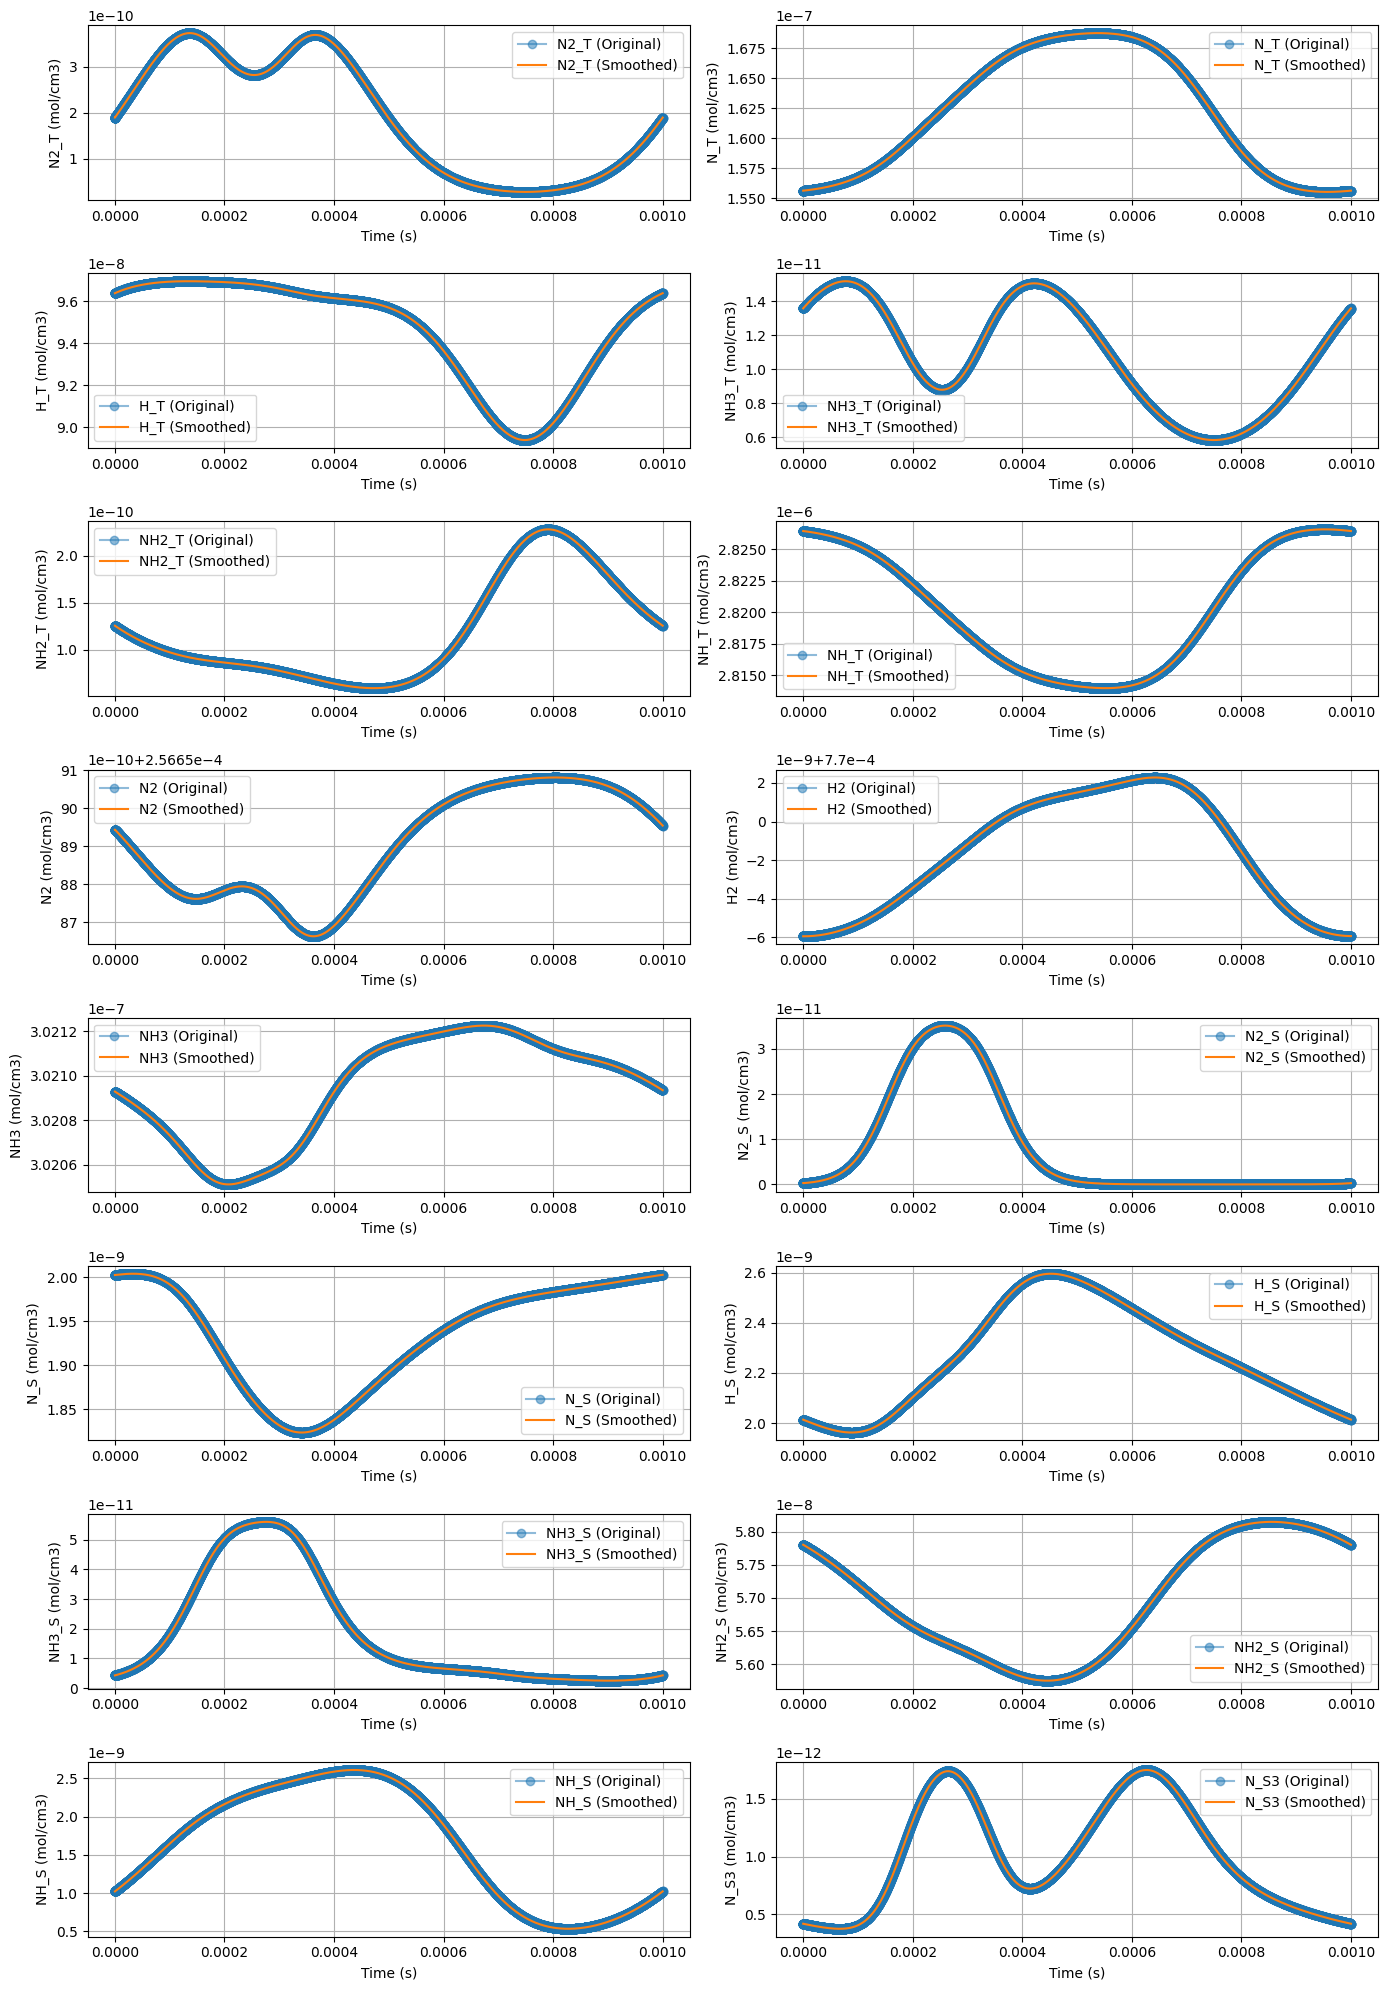

In [64]:
fig, axs = plt.subplots(8, 2, figsize=(14, 20))  
axs = axs.flatten()

for i, name in enumerate(column_names):
    axs[i].plot((sol_.t-5), sol_.y[i], 'o-', alpha=0.5, label=f'{name} (Original)')
    axs[i].plot(smoothed_variables["time"], smoothed_variables[name], '-', label=f'{name} (Smoothed)')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f'{name} (mol/cm3)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [65]:
smoothed_variables["time"]

array([0.00000000e+00, 1.00000008e-10, 2.00000017e-10, ...,
       9.99842390e-04, 9.99942390e-04, 1.00000000e-03])

3.0209424365845394e-07

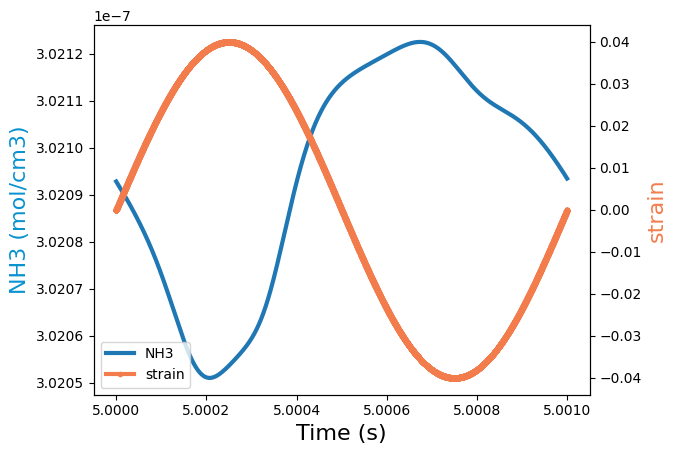

In [66]:
amplitude = 0.04
t = sol_.t
strain = amplitude * np.sin(2 * np.pi * freq_osci * t)
# strain = amplitude * signal.square(2 * np.pi * freq_osci * t)

# Creating the two plots in the same frame
fig, ax1 = plt.subplots()
# Creating the first plot: times x TOF plot
ax1.plot(t, sol_.y[8], label='NH3', linewidth=3)
ax1.set_ylabel('NH3 (mol/cm3)', color ='#0892d0', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=16)

# Creating the second plot: times x BEa with axes on the right side
ax2 = ax1.twinx()
ax2.plot(t, strain, label='strain', color='#f37c4c', linewidth=3, marker='.')
ax2.set_ylabel('strain', color ='#f37c4c', fontsize=16)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left');

# ax1.set_ylim(0.0002566, 0.0002568);
# ax1.set_xlim(25,30);

# # # # ax2.set_ylim(0.0002566, 0.0002568);  
# ax2.set_xlim(25, 30);
np.mean(sol_.y[8])

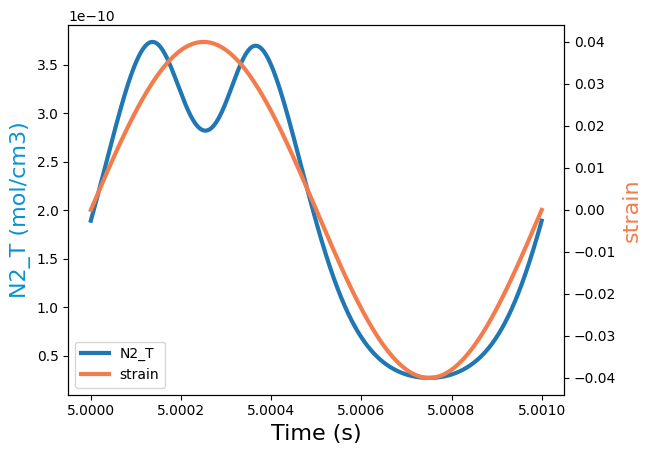

In [67]:
# Creating the two plots in the same frame
fig, ax1 = plt.subplots()
# Creating the first plot: times x TOF plot
ax1.plot(t, sol_.y[0], label='N2_T', linewidth=3)
ax1.set_ylabel('N2_T (mol/cm3)', color ='#0892d0', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=16)

# Creating the second plot: times x BEa with axes on the right side
ax2 = ax1.twinx()
ax2.plot(t, strain, label='strain', color='#f37c4c', linewidth=3)
ax2.set_ylabel('strain', color ='#f37c4c', fontsize=16)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left');

In [69]:
N2_T = sol.y[0] # 0
N_T = sol.y[1]  # 1
H_T = sol.y[2] # 2
NH3_T = sol.y[3] # 3
NH2_T = sol.y[4]# 4
NH_T = sol.y[5] # 5

N2 = sol.y[6] # 6
H2 = sol.y[7] # 7
NH3 = sol.y[8] # 8

N2_S = sol.y[9] # 9
N_S = sol.y[10] # 10
H_S = sol.y[11] # 11
NH3_S = sol.y[12] # 12
NH2_S = sol.y[13] # 13
NH_S = sol.y[14] # 14
N_S3 = sol.y[15] # 15

np.shape(N2)

(617408,)

In [70]:
species1 = ['N2(T)','N(T)','H(T)','NH3(T)','NH2(T)','NH(T)','N2','H2']
species2 = ['NH3','N2(S)','N(S)','H(S)','NH3(S)','NH2(S)','NH(S)','N(S3)']

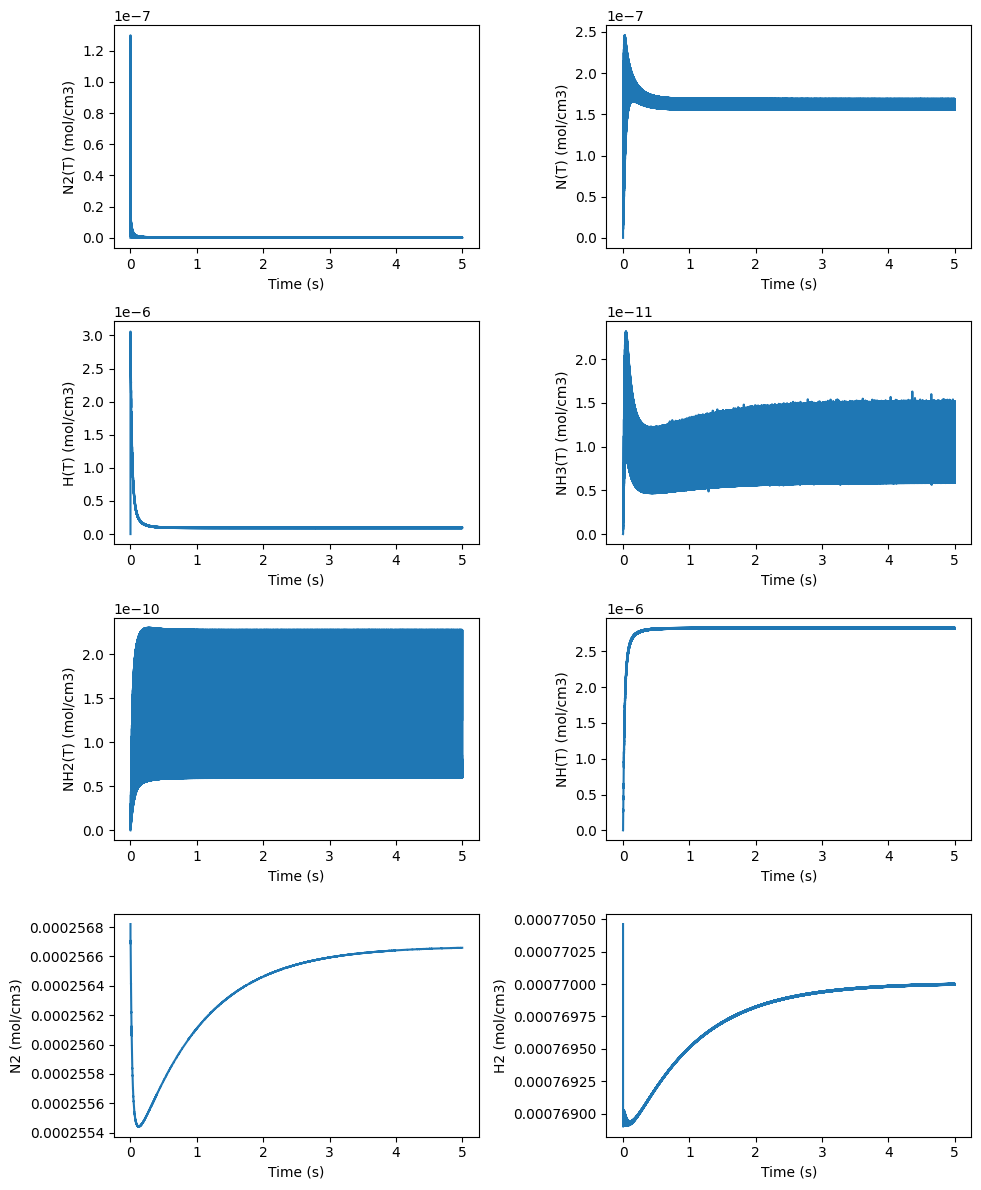

In [71]:
fig, axs = plt.subplots(4, 2, figsize=(10,12)) 

row_index = 0
col_index = 0

ylabel = {i: f'{species1[i]}' for i in (range(8))}

for i in range(8):
    axs[row_index, col_index].plot(sol.t, sol.y[i], '-')
    
    axs[row_index, col_index].set_xlabel('Time (s)')
    axs[row_index, col_index].set_ylabel(f'{ylabel[i]} (mol/cm3)')

    col_index += 1
    if col_index == 2:
        col_index = 0
        row_index += 1

plt.tight_layout()

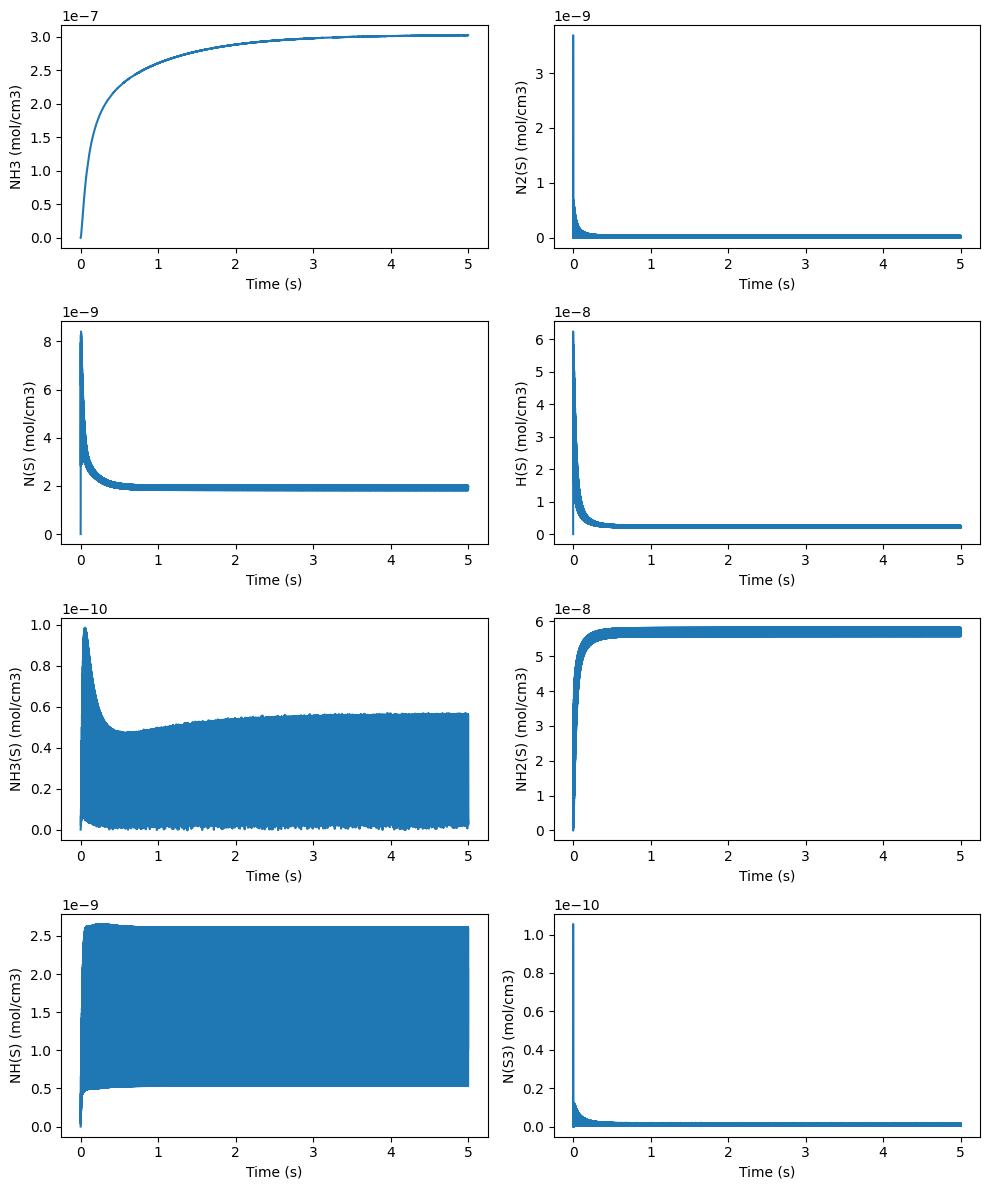

In [78]:
fig, axs = plt.subplots(4, 2, figsize=(10,12)) 

row_index = 0
col_index = 0

ylabel = {j: f'{species2[j]}' for j in range(8)}

for i, j in enumerate([8,9,10,11,12,13,14,15]):
    axs[row_index, col_index].plot(sol.t, sol.y[j], '-')

    axs[row_index, col_index].set_xlabel('Time (s)')
    axs[row_index, col_index].set_ylabel(f'{ylabel[i]} (mol/cm3)') 

    col_index += 1
    if col_index == 2:
        col_index = 0
        row_index += 1

plt.tight_layout()
plt.show()

In [139]:
t = sol_.t

gradients = []
odes = []


for i in range(16):

    gradient = np.gradient(sol_.y[i] , t) # LHS
    from_function = np.array([ODEs(ti, yi) for ti, yi in zip(sol_.t, sol_.y.T)])[:, i] # RHS
    
    gradients.append(gradient)
    odes.append(from_function)

    falses = 0

    for j, (grad, ode) in enumerate(zip(gradient, from_function)):
        is_close = np.isclose(grad, ode, atol=1e-10) 
        if not is_close:
            falses += 1

    print(f"{i}: {falses}")
    
print(f'OBS: Out of {len(t)}')
    

0: 1310
1: 25
2: 25
3: 10
4: 28
5: 33
6: 1396
7: 38
8: 24
9: 231
10: 13
11: 20
12: 20
13: 32
14: 32
15: 12
OBS: Out of 10028


In [82]:
species1 = ['N2(T)','N(T)','H(T)','NH3(T)','NH2(T)','NH(T)','N2','H2']
species2 = ['NH3','N2(S)','N(S)','H(S)','NH3(S)','NH2(S)','NH(S)','N(S3)']

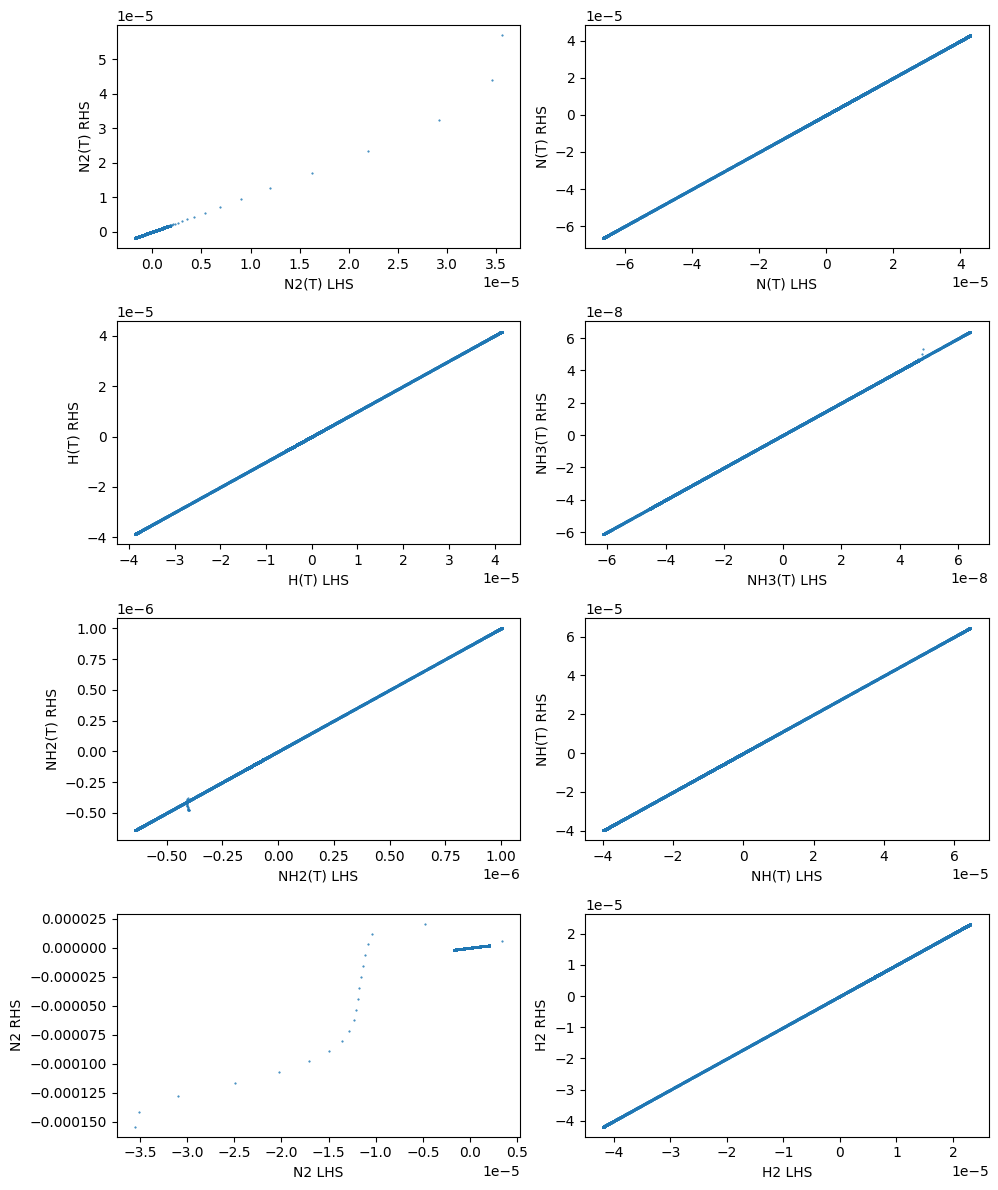

In [83]:
fig, axs = plt.subplots(4, 2, figsize=(10,12)) 

row_index = 0
col_index = 0

ylabel = {i: f'{species1[i]}' for i in (range(8))}

for i in range(8):
    axs[row_index, col_index].plot(gradients[i], odes[i], '.', markersize = 1)
    
    axs[row_index, col_index].set_xlabel(f'{ylabel[i]} LHS')
    axs[row_index, col_index].set_ylabel(f'{ylabel[i]} RHS')

    col_index += 1
    if col_index == 2:
        col_index = 0
        row_index += 1

plt.tight_layout()

(-5e-07, 1e-05)

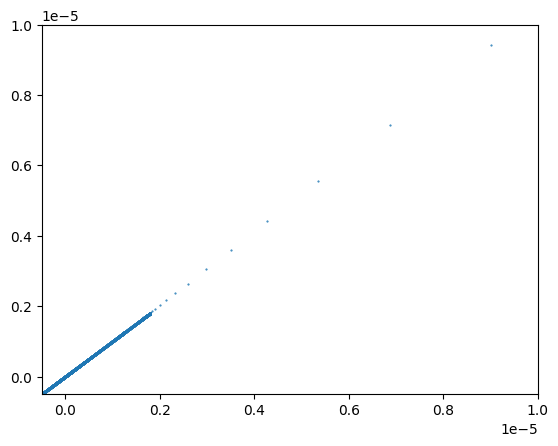

In [137]:
plt.plot(gradients[0], odes[0], '.', markersize = 1)
plt.ylim(-0.05e-5, 1e-5)
plt.xlim(-0.05e-5, 1e-5)

(-5e-06, 3e-06)

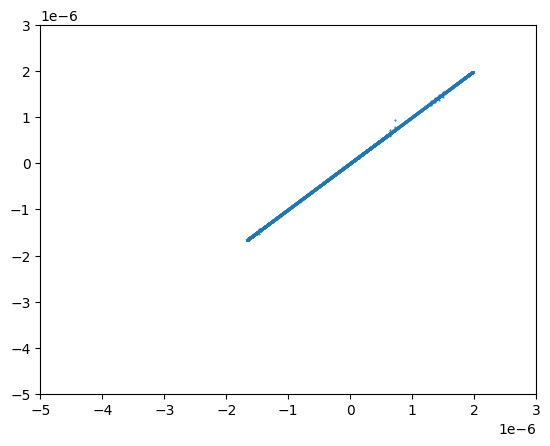

In [133]:
plt.plot(gradients[6], odes[6], '.', markersize = 1)
plt.ylim(-0.5e-5, 0.3e-5)
plt.xlim(-0.5e-5, 0.3e-5)

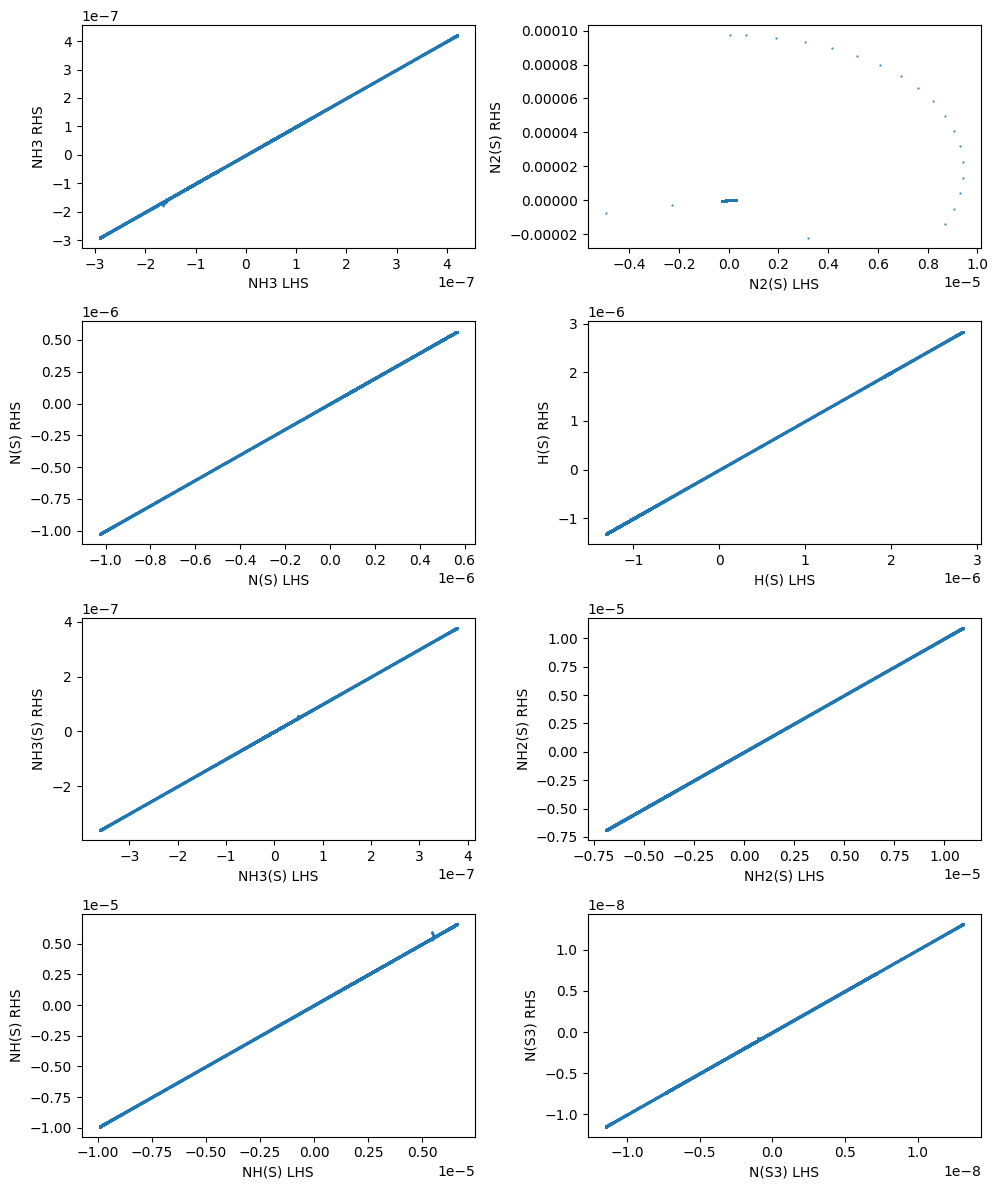

In [84]:
fig, axs = plt.subplots(4, 2, figsize=(10,12)) 

row_index = 0
col_index = 0

ylabel = {i: f'{species2[i]}' for i in (range(8))}

for i, j in enumerate([8,9,10,11,12,13,14,15]):
    axs[row_index, col_index].plot(gradients[j], odes[j], '.', markersize = 1)
    
    axs[row_index, col_index].set_xlabel(f'{ylabel[i]} LHS')
    axs[row_index, col_index].set_ylabel(f'{ylabel[i]} RHS')

    col_index += 1
    if col_index == 2:
        col_index = 0
        row_index += 1

plt.tight_layout()

(-1e-06, 5e-07)

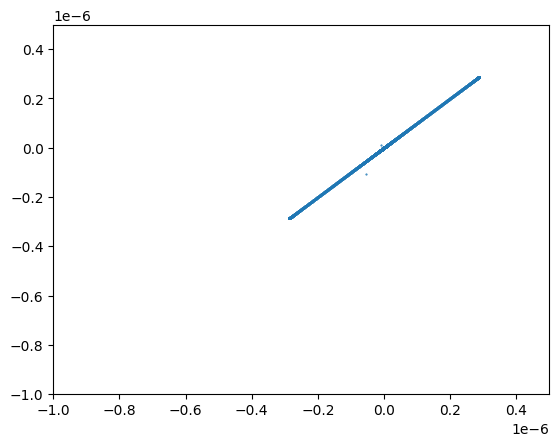

In [136]:
plt.plot(gradients[9], odes[9], '.', markersize = 1)
plt.ylim(-1e-6, 0.5e-6)
plt.xlim(-1e-6, 0.5e-6)

In [ ]:
result = sol_.y[:,-1]

NH3_MF = result[8] / (result[6] + result[7] + result[8])

NH2_Conv = 1-((1 - NH3_MF)/(1 + NH3_MF))
Conv = NH2_Conv * 100
NH3_TOF = c_N2 * Q_in * NH2_Conv/ SDTOT/ abyv
Conv, NH3_MF, NH3_TOF

(0.05881554584948878, 0.00029416423639813845, 0.04806604589169816)

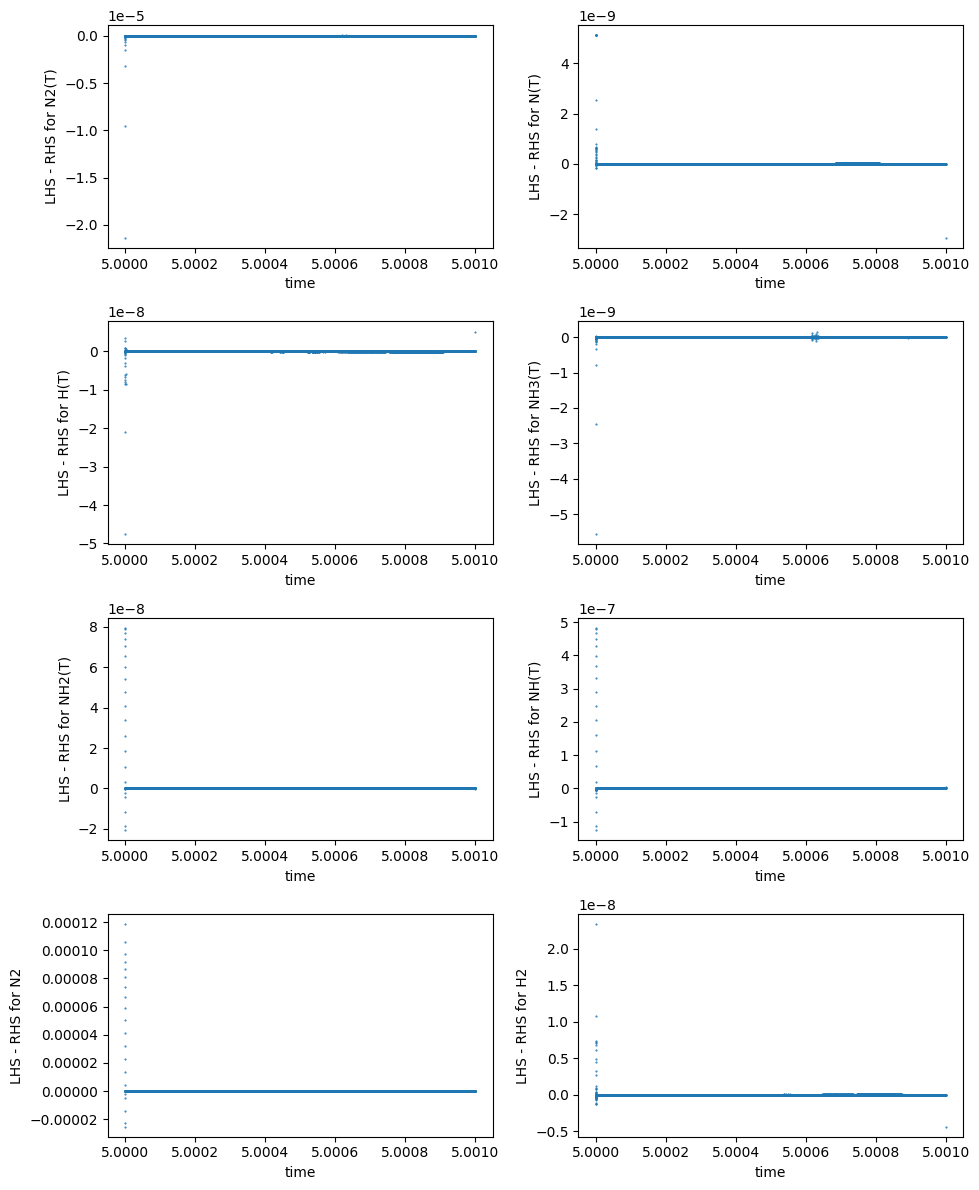

In [85]:
fig, axs = plt.subplots(4, 2, figsize=(10,12)) 

row_index = 0
col_index = 0

ylabel = {i: f'{species1[i]}' for i in (range(8))}

for i in range(8):
    axs[row_index, col_index].plot(t, gradients[i] - odes[i], '.', markersize = 1)
    
    axs[row_index, col_index].set_xlabel(f'time')
    axs[row_index, col_index].set_ylabel(f'LHS - RHS for {ylabel[i]}')

    col_index += 1
    if col_index == 2:
        col_index = 0
        row_index += 1

plt.tight_layout()

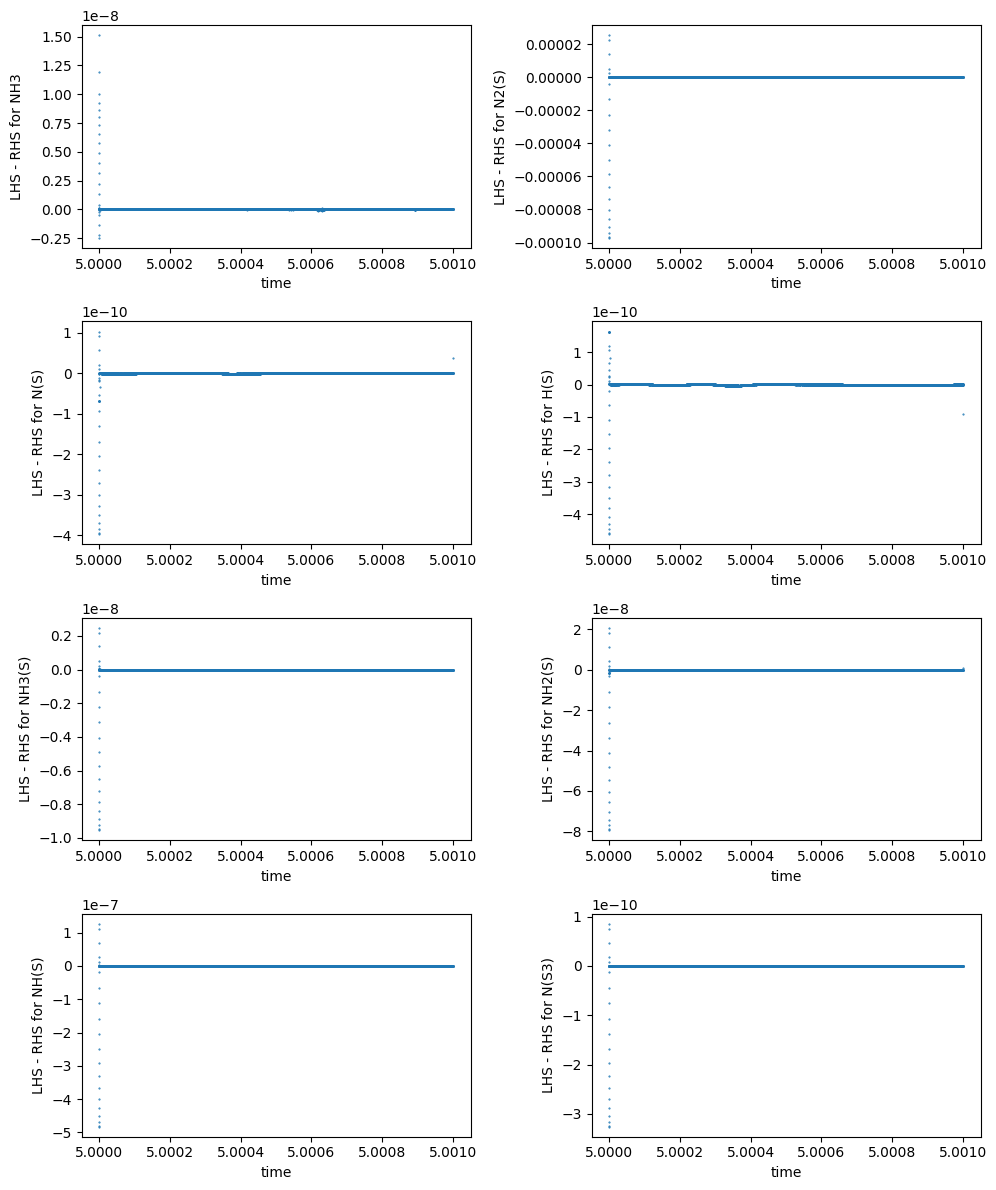

In [86]:
fig, axs = plt.subplots(4, 2, figsize=(10,12)) 

row_index = 0
col_index = 0

ylabel = {i: f'{species2[i]}' for i in (range(8))}

for i, j in enumerate([8,9,10,11,12,13,14,15]):
    axs[row_index, col_index].plot(t, gradients[j] - odes[j], '.', markersize = 1)
    
    axs[row_index, col_index].set_xlabel(f'time')
    axs[row_index, col_index].set_ylabel(f'LHS - RHS for {ylabel[i]}')

    col_index += 1
    if col_index == 2:
        col_index = 0
        row_index += 1

plt.tight_layout()

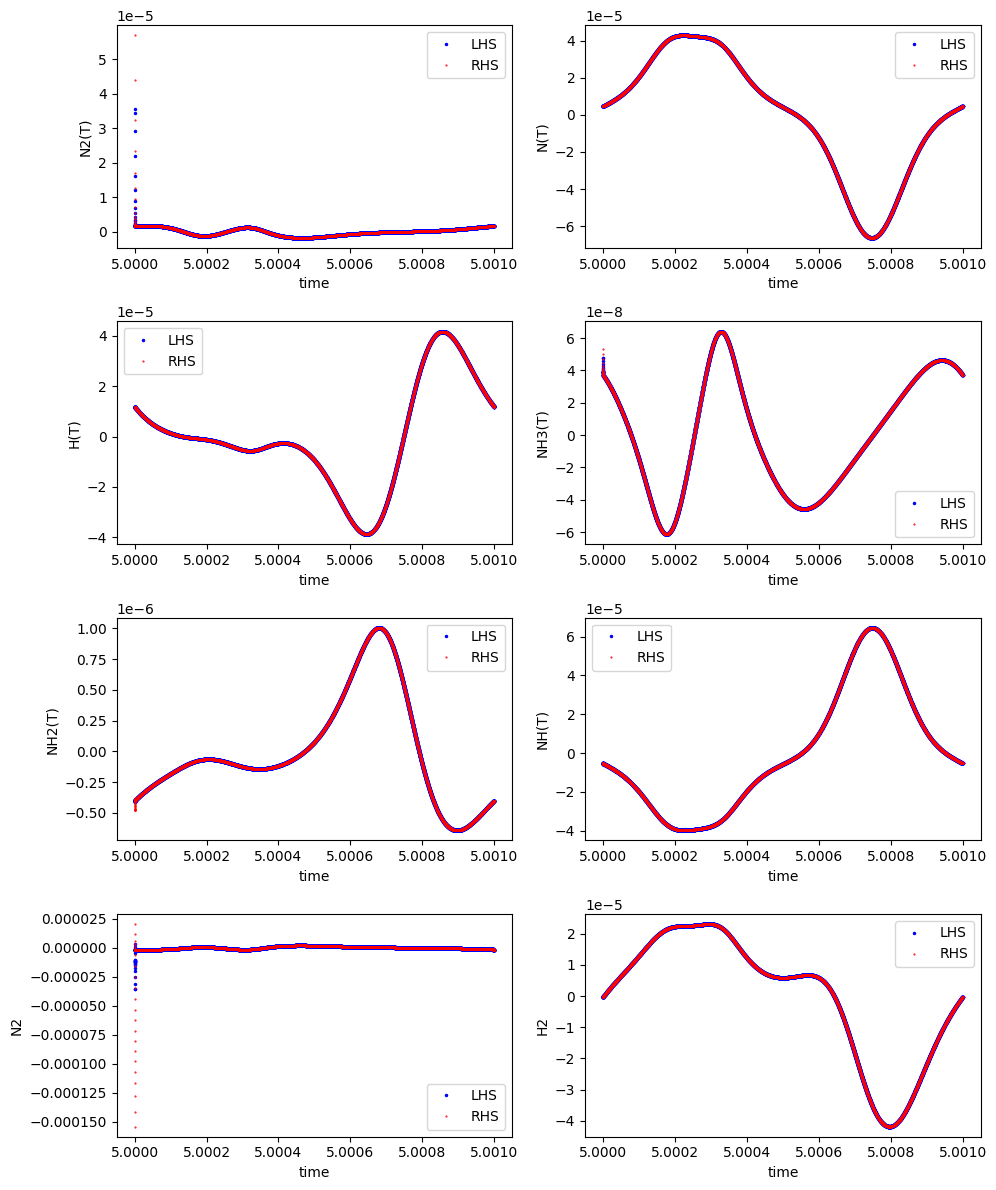

In [87]:
fig, axs = plt.subplots(4, 2, figsize=(10,12)) 

row_index = 0
col_index = 0

ylabel = {i: f'{species1[i]}' for i in (range(8))}

for i in range(8):
    axs[row_index, col_index].plot(t, gradients[i], 'b.', markersize = 3, label = 'LHS')
    axs[row_index, col_index].plot(t, odes[i], 'r.',  markersize = 1, label = 'RHS')
    
    axs[row_index, col_index].set_xlabel(f'time')
    axs[row_index, col_index].set_ylabel(f'{ylabel[i]}')
    axs[row_index, col_index].legend()

    col_index += 1
    if col_index == 2:
        col_index = 0
        row_index += 1

plt.tight_layout()

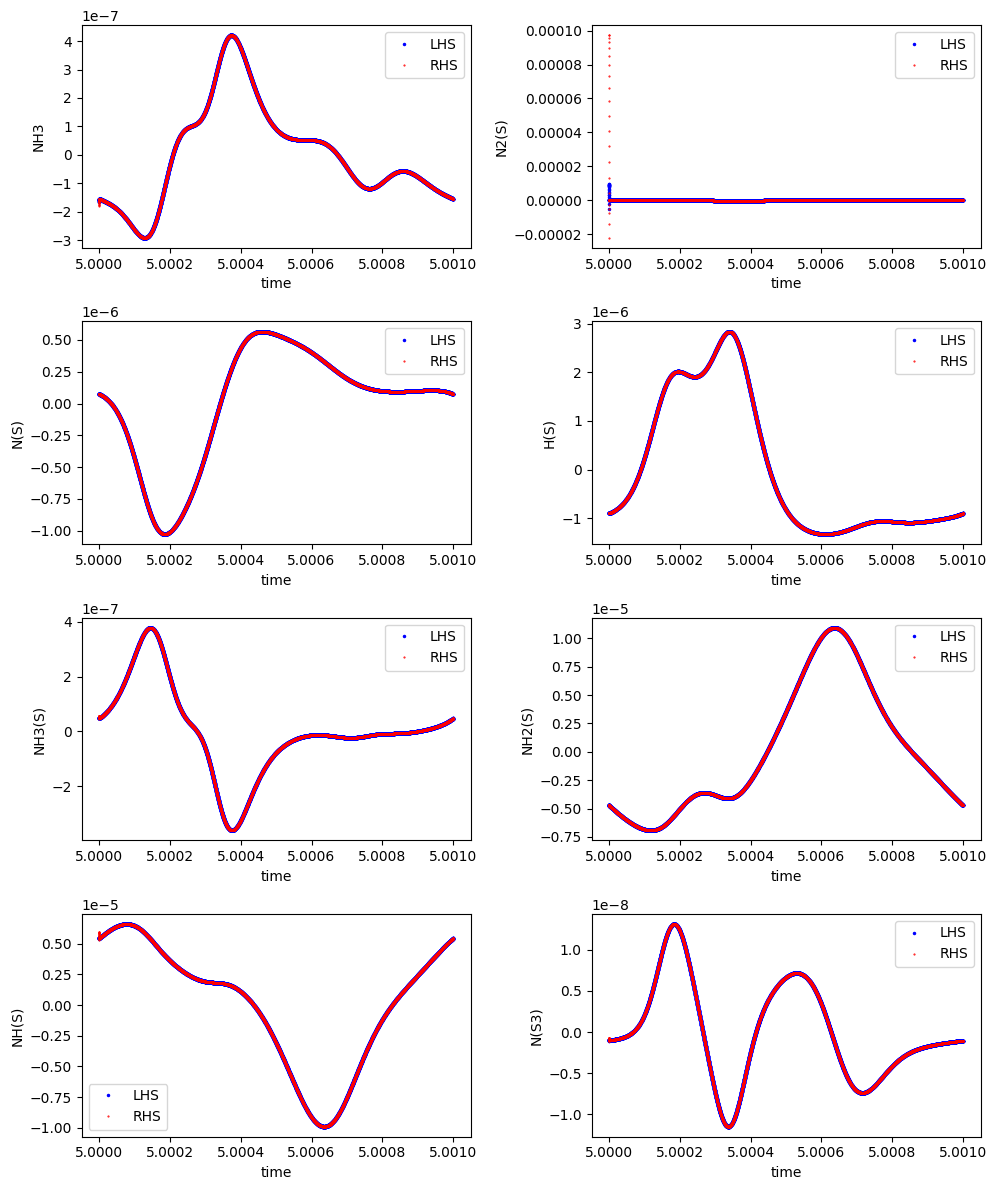

In [88]:
fig, axs = plt.subplots(4, 2, figsize=(10,12)) 

row_index = 0
col_index = 0

ylabel = {i: f'{species2[i]}' for i in (range(8))}

for i, j in enumerate([8,9,10,11,12,13,14,15]):
    axs[row_index, col_index].plot(t, gradients[j], 'b.', markersize = 3, label = 'LHS')
    axs[row_index, col_index].plot(t, odes[j], 'r.',  markersize = 1, label = 'RHS')
    
    axs[row_index, col_index].set_xlabel(f'time')
    axs[row_index, col_index].set_ylabel(f'{ylabel[i]}')
    axs[row_index, col_index].legend()

    col_index += 1
    if col_index == 2:
        col_index = 0
        row_index += 1

plt.tight_layout()

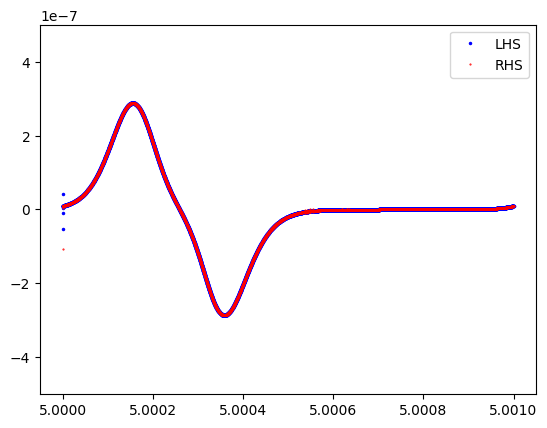

In [124]:
plt.plot(t, gradients[9], 'b.', markersize = 3, label = 'LHS')
plt.plot(t, odes[9], 'r.',  markersize = 1, label = 'RHS')
plt.ylim(-0.0000005, 0.0000005)
plt.legend()

In [ ]:
result = sol_.y[:,-1]

NH3_MF = result[8] / (result[6] + result[7] + result[8])

NH2_Conv = 1-((1 - NH3_MF)/(1 + NH3_MF))
Conv = NH2_Conv * 100
NH3_TOF = c_N2 * Q_in * NH2_Conv/ SDTOT/ abyv
Conv, NH3_MF, NH3_TOF

(0.05881554584948878, 0.00029416423639813845, 0.04806604589169816)